# RC low pass filter
## Solving by solving the ODE.

Solving a circuit by computing a numerical solution for the _differential equation_ that represents the circuit has a certain elegance, but for complicated circuits, this gets much harder than computing the transfer function and using FFTs to see how the circuit affects a particular signar.

The advantage of solving the differential equation, as you will see if you look carefully, is that this will work on a continuous input, and is therefore the best way to use for filtering a continuous digital input signal.

We start with the differential equation that we found for an RC low pass filter:

$$
\frac{d V_c}{d t} = \frac{1}{RC}( V_{in} - V_c)
$$

Turn this into a "first order forward difference" equation:


\begin{equation*}
\begin{split}
(V_{i+1}^c - V_{i}^c)/\Delta t &= \frac{1}{RC}(V_{i}^{in} - V_{i}^c) \Rightarrow \\
V_{i+1}^c &=\frac{1}{RC}(V_{i}^{in} - V_{i}^c)\Delta t + V_{i}^c
\end{split}
\end{equation*}


An explanation of taking derivatives and the forward and backward difference equations is found near the end of the 601 [notebook on basic calculus](https://github.com/mholtrop/Phys601/blob/master/Notebooks/04_Basic_Calculus.ipynb). More details on using the scipy differential equation solver is found in [Ordinary_Differential_Equations](https://github.com/mholtrop/Phys601/blob/master/Notebooks/A01_Ordinary_Differential_Equations.ipynb).

We can try to solve the ODE now using the forward difference equation. We expect it won't be very accurate, but that it should give a decent result for small $\Delta t$. Let's try.

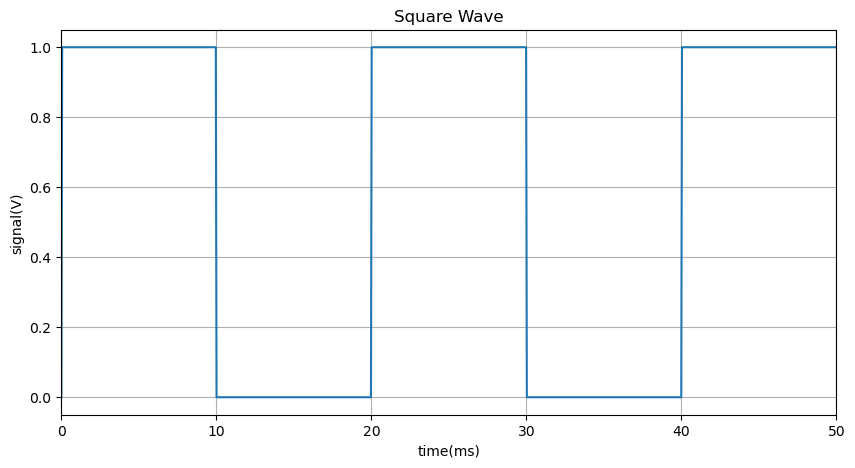

In [8]:
%matplotlib inline
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
#
# Setup an input square wave signal.
#
F = 50.                 # Frequency of the square wave.
T = .05                 # Amount of time to simulate
N = 2**10                # Number of time steps. Choose small to see a difference between the methods.
DT = T/N                # Delta T
indexes = range(N)
t = np.array([i*DT for i in indexes]) # Array containing the desired time steps.

def square_wave(ti,A,F):             
    # Define a function for the square wave.
    # input ti = current time
    # input A  = Amplitude
    # input F  = Frequency.
    # The following is a bit tricky: If you look at t*2*F, then for the first half of the square
    # wave, this will give numbers between 0 and 1, and for the second half, between 1 and 2. The 'int' of
    # that number will be 0 for the first half, 1 for the second, 2 for the third etc. So then the remainder
    # when dividing those integer by 2 will give 0,0,0,...,1,1,1..., etc in exactly the pattern we want.
    return(A*(1-np.array(ti*2*F,dtype="int")%2))

Vin   = square_wave(t,1,F) # 0.5+0.5*signal.square(2*np.pi*F*t) # Create a square wave wiht a 2 Volt peak to peak (-1V to +1V)
Vin[0]= 0                         # We must start at 0!!!!
plt.figure(figsize=(10,5))
plt.plot(1000*t,Vin )             # Change the x-axis scale to ms by multiplying by 10^3
ax = plt.gca()
ax.set_xlim(0.,50.)               # Show only the first 50 ms of the signal
plt.grid(True)
plt.title("Square Wave")
plt.xlabel("time(ms)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
plt.show()

### Setting up the ODE


We now step through the problem in a simple loop. Each next step is computed from the 
previous one, as we have shown above.
$$
\begin{equation*}
V_{i+1}^c = \frac{1}{RC}(V_{i}^{in} - V_{i}^c)\Delta t + V_{i}^c 
\end{equation*}
$$
Since the i+1 depends on the i, we cannot use a simple Numpy call. Instead we just compute this as a loop over i. Note that because of the i+1, we need to make Vc one step larger. When plotting we need to remember that.

In [2]:
# Some reasonable values for R=2kΩ and C= 1µF
R = 1.e+3
C = 1.e-6
Vc = np.zeros(len(Vin)+1)  # A zero array of the needed length.
Vc[0] = Vin[0]           # Initialize the first step.
for i in indexes:  # Careful, we cannot do the last step because of the i+1 !!!
    Vc[i+1] = (Vin[i]-Vc[i])*DT/(R*C) + Vc[i]

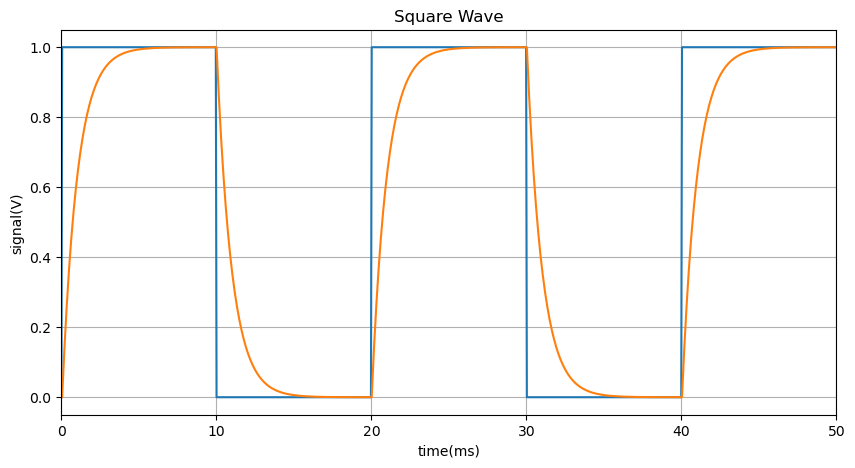

In [3]:
plt.figure(figsize=(10,5))
plt.plot(1000*t,Vin,label="Vin" )             # Change the x-axis scale to ms by multiplying by 10^3
plt.plot(1000*t,Vc[:-1],label="Vout")
ax = plt.gca()
ax.set_xlim(0.,50.)               # Show only the first 50 ms of the signal
plt.grid(True)
plt.title("Square Wave")
plt.xlabel("time(ms)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
plt.show()

This result is actually pretty good, it is very close to what we expect, and what you measured at in the lab.

### Using the scipy ODE solver

If you want be more accurate, without doing a lot more computation, you can implement this as a Runga-Kutta 4th order ODE. The details of how to do this can be found in many places. Here, I will just show how to use the solver that is already implemented for you in the scipy package.

The ODE solver is called "integrate" because essentially that is what it is doing, it it integrating out the ODE step by step. The method requires you to provide it with a function that computes the derivative of the value (or values) that you are interested in. In our case, this depends on the time step as well, because the input depends on the time step. The function however gets the _time_ $t$, so we need to compute back to the index $i$ that this corresponds to. Alternatively, you can replace ```Vin[i]``` with square_wave(ti,A,F). 


In [4]:
import scipy.integrate as spi

def RC_lowpass(inp,ti,param):
    # The input "inp" will be the Vc at the current step i. 
    # The input "ti" is the current time step. If we keep that as the integer step, instead of the
    # actual time t, then we can use Vin[t] in our equation, where Vin is a global variable.
    # If we want ti to actually represent time, then we need to replace Vin[ti] with a function call
    # Vin(ti), which means we need to define the function Vin.
    # 
    Vci = inp[0]
    R   = param[0] # The parameters are passed to the funtion in "param". You decide what goes in there.
    C   = param[1]
    DT  = param[2]
    i   = int(ti/DT)
    if i >= len(Vin): i=len(Vin)-1
    dVci = (Vin[i] - Vci)/(R*C)  # This is the equation we had in the introduction.
    return([dVci])
 


In [5]:
solution = spi.odeint(RC_lowpass,Vc[0],t,args=([R,C,DT],))

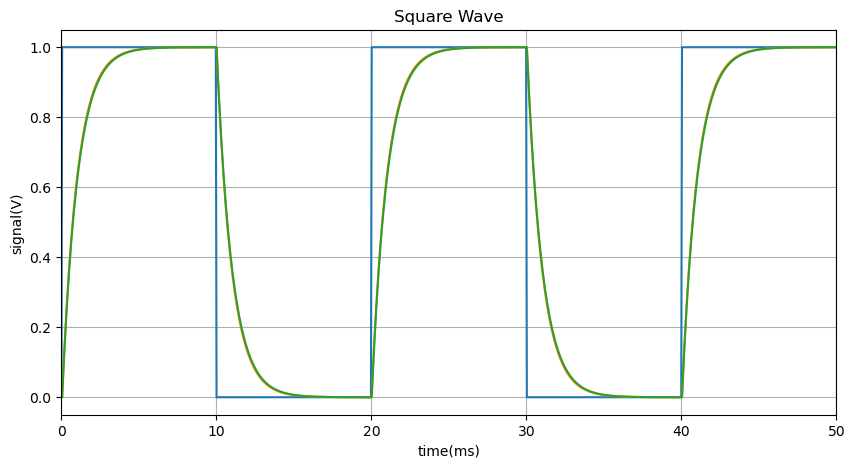

In [6]:
plt.figure(figsize=(10,5))
plt.plot(1000*t,Vin,label="Vin" )             # Change the x-axis scale to ms by multiplying by 10^3
plt.plot(1000*t,Vc[:-1],label="Vout")
plt.plot(1000*t,solution,label="Vout 4th order")
ax = plt.gca()
ax.set_xlim(0.,50.)               # Show only the first 50 ms of the signal
plt.grid(True)
plt.title("Square Wave")
plt.xlabel("time(ms)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
plt.show()

You see that both solutions are _very_ close. If you increase N a bit further, they become indistinguishable, if you decrease N, the difference gets larger.